In [1]:
import polars as pl
import numpy as np
import data_actions.data_processing.utils as utils

In [2]:
data = utils.load_data("data/original_data")

c:\Users\Adam\Pulpit\STUDIA\SEM6\SP2\RecSysMain\RecSys2025\data_actions\data_processing\utils.py:67: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  if "timestamp" in df.columns:


In [3]:
data["targets"]["active_clients"]

memmap([17649961, 16696114, 10238779, ...,  7535041,  4284680, 20304565],
       shape=(750860,))

In [4]:
utils.calculate_days_since_start(data)
days_since_start = pl.concat([data["events"][df].select("days_since_start") for df in data["events"]])
max_day = days_since_start.max().collect().item()
TARGET_START_DAY = max_day - 27
VAL_START_DAY = max_day - 20
TEST_START_DAY = max_day - 13
print(f"TARGET_START_DAY: {TARGET_START_DAY}")
print(f"VAL_START_DAY: {VAL_START_DAY}")
print(f"TEST_START_DAY: {TEST_START_DAY}")

TARGET_START_DAY: 113
VAL_START_DAY: 120
TEST_START_DAY: 127


In [5]:
from enum import Enum


class PropensityTasks(Enum):
    PROPENSITY_CATEGORY = "propensity_category"
    PROPENSITY_SKU = "propensity_sku"

class ChurnTargetCalculator:
    @property
    def target_dim(self) -> int:
        return 1

    def compute_target(self, client_id: int, target_df: pl.LazyFrame) -> np.ndarray:
        target = np.zeros(self.target_dim, dtype=np.float32)
        target[0] = 1 if target_df.filter(pl.col("client_id") == client_id).collect().is_empty() else 0
        return target

def get_propensity_column(task: PropensityTasks) -> str:
    """
    Method for obtaining the string representation of the column of a
    propensity task. For example:

    PropensityTasks.PropensitySku -> sku
    """
    return task.value.split("_")[-1]

class PropensityTargetCalculator:
    def __init__(self, task: PropensityTasks, propensity_targets: np.ndarray):
        """
        Args:
            task (PropensityTask): propensity task for target calculator
            propensity_targets (np.ndarray): propensity targets.
        """

        self._propensity_type = get_propensity_column(task=task)
        self._propensity_targets = propensity_targets

    @property
    def target_dim(self) -> int:
        return len(self._propensity_targets)

    def compute_target(self, client_id: int, target_df: pl.LazyFrame) -> np.ndarray:
        target = np.zeros(self.target_dim, dtype=np.float32)
        cats_in_target = target_df.filter(pl.col("client_id") == client_id).collect().to_pandas()[
            self._propensity_type
        ].unique()
        target[
            np.isin(self._propensity_targets, cats_in_target, assume_unique=True)
        ] += 1
        return target


In [6]:
data_cart = data["events"]["add_to_cart"].filter(pl.col("days_since_start") >= TARGET_START_DAY).filter(pl.col("days_since_start") < VAL_START_DAY)
data_remove = data["events"]["remove_from_cart"].filter(pl.col("days_since_start") >= TARGET_START_DAY).filter(pl.col("days_since_start") < VAL_START_DAY)
#data_page = data["events"]["page_visit"].filter(pl.col("days_since_start") >= TARGET_START_DAY).filter(pl.col("days_since_start") < VAL_START_DAY)
data_buy = data["events"]["product_buy"].filter(pl.col("days_since_start") >= TARGET_START_DAY).filter(pl.col("days_since_start") < VAL_START_DAY)
data_search = data["events"]["search_query"].filter(pl.col("days_since_start") >= TARGET_START_DAY).filter(pl.col("days_since_start") < VAL_START_DAY)


In [7]:
targets = []
targets_cart = []
#targets_page = []
targets_remove = []
targets_buy = []
targets_search = []
active_clients_ids = data["targets"]["active_clients"][:100]

for client_id in active_clients_ids:
    targets_cart.append(ChurnTargetCalculator().compute_target(client_id, data_cart)[0])
    #targets_page.append(ChurnTargetCalculator().compute_target(client_id, data_page)[0])
    targets_remove.append(ChurnTargetCalculator().compute_target(client_id, data_remove)[0])
    targets_buy.append(ChurnTargetCalculator().compute_target(client_id, data_buy)[0])
    targets_search.append(ChurnTargetCalculator().compute_target(client_id, data_search)[0])

In [8]:
data["targets"]["active_clients"].shape

(750860,)

In [ ]:
propensity_sku = data["targets"]["propensity_sku"]
propensity_category = data["targets"]["propensity_category"]

buy_data = data["events"]["product_buy"]
cart_data = data["events"]["add_to_cart"]
remove_data = data["events"]["remove_from_cart"]
page_data = data["events"]["page_visit"]
search_data = data["events"]["search_query"]

products = data["products"]["product_properties"]

product_buy_with_category = products.join(buy_data, on="sku", how="inner")
add_to_cart_with_category = products.join(cart_data, on="sku", how="inner")
remove_from_cart_with_category = products.join(remove_data, on="sku", how="inner")
page_visit_with_category = products.join(page_data, on="sku", how="inner")
search_query_with_category = products.join(search_data, on="sku", how="inner")


prop_sku = PropensityTargetCalculator(PropensityTasks.PROPENSITY_SKU, propensity_sku)
sku_targets = []

for client_id in active_clients_ids:
    sku_targets.append(prop_sku.compute_target(client_id, cart_data))

for s in sku_targets:
    print(len([tar for tar in s if tar > 0]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [10]:
prop_cat = PropensityTargetCalculator(PropensityTasks.PROPENSITY_CATEGORY, propensity_category)
cat_targets = []

for client_id in active_clients_ids:
    cat_targets.append(prop_cat.compute_target(client_id, add_to_cart_with_category))

for c in cat_targets:
    print(len([tar for tar in c if tar > 0]))

1
0
1
1
0
2
1
0
0
1
0
0
1
0
1
1
0
1
1
3
0
1
0
0
1
1
0
0
1
0
0
2
0
0
2
3
2
0
1
0
0
1
0
1
0
0
0
0
0
0
1
1
0
1
2
3
0
1
0
0
0
0
1
2
1
0
0
0
0
0
0
0
2
0
0
1
1
1
0
1
0
1
0
2
1
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0


Accuracy: 0.95
client_id: 33.75
sku: 41.80
days_since_start: 24.45


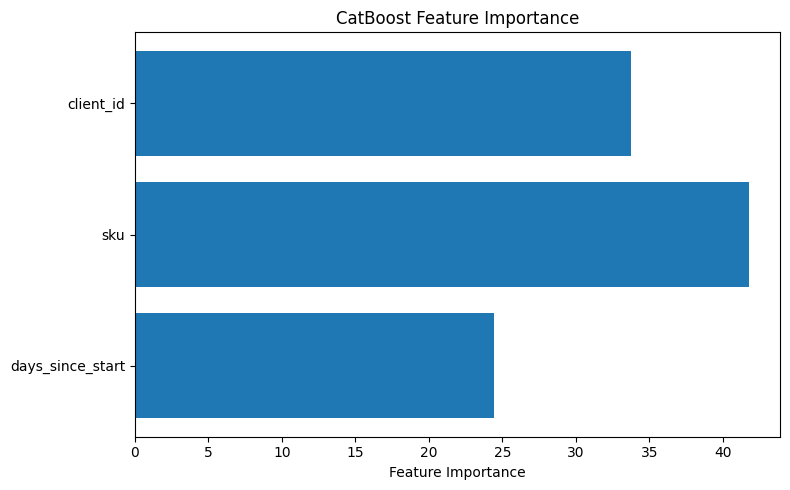

In [11]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

X = data_buy.collect().to_pandas().head(100)
X = X.drop(columns=["timestamp"])
y = pd.Series(targets_buy, name="target")

model = CatBoostClassifier(verbose=0)
model.fit(X, y)


importances = model.get_feature_importance()
features = X.columns

y_pred = model.predict(X)

acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.2f}")

for f, imp in zip(features, importances):
    print(f"{f}: {imp:.2f}")


plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Accuracy: 0.99
client_id: 35.01
sku: 42.10
days_since_start: 22.89


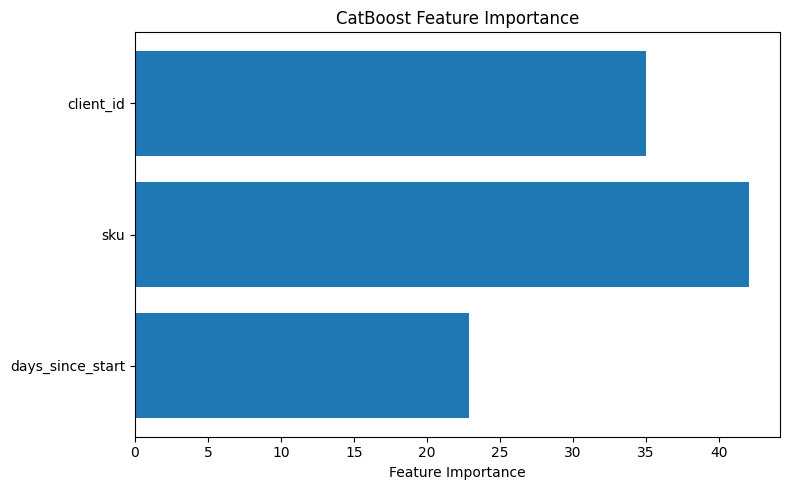

In [13]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

X = data_remove.collect().to_pandas().head(100)
X = X.drop(columns=["timestamp"])
y = pd.Series(targets_remove, name="target")

model = CatBoostClassifier(verbose=0)
model.fit(X, y)


importances = model.get_feature_importance()
features = X.columns

y_pred = model.predict(X)

acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.2f}")

for f, imp in zip(features, importances):
    print(f"{f}: {imp:.2f}")


plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Accuracy: 0.96
client_id: 54.84
sku: 34.57
days_since_start: 10.59


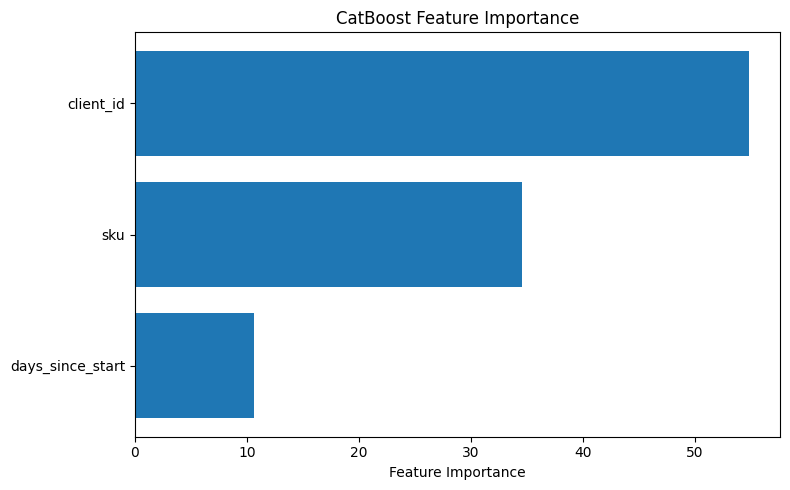

In [12]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

X = data_cart.collect().to_pandas().head(100)
X = X.drop(columns=["timestamp"])
y = pd.Series(targets_cart, name="target")

model = CatBoostClassifier(verbose=0)
model.fit(X, y)


importances = model.get_feature_importance()
features = X.columns

y_pred = model.predict(X)

acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.2f}")

for f, imp in zip(features, importances):
    print(f"{f}: {imp:.2f}")


plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Accuracy: 0.96
client_id: 64.04
days_since_start: 35.96


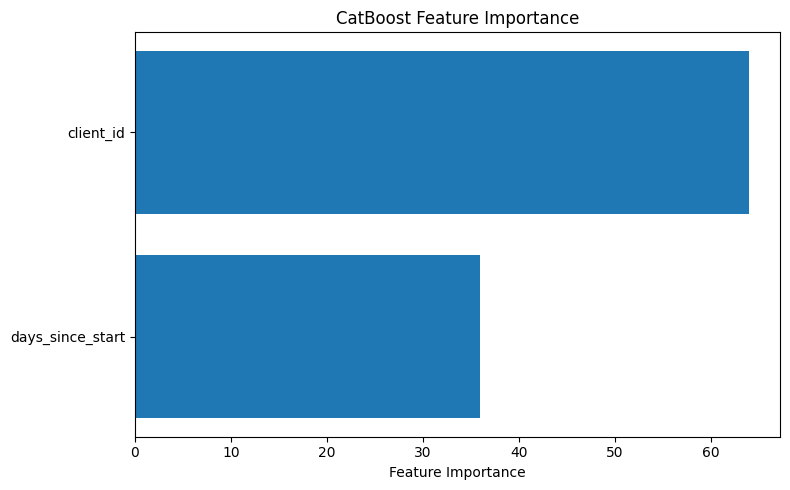

In [14]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

X = data_search.collect().to_pandas().head(100)
X = X.drop(columns=["query"])
X = X.drop(columns=["timestamp"])
y = pd.Series(targets_search, name="target")

model = CatBoostClassifier(verbose=0)
model.fit(X, y)


importances = model.get_feature_importance()
features = X.columns

y_pred = model.predict(X)

acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.2f}")

for f, imp in zip(features, importances):
    print(f"{f}: {imp:.2f}")


plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [15]:
data_page = data["events"]["page_visit"].filter(pl.col("days_since_start") >= TARGET_START_DAY).filter(pl.col("days_since_start") < VAL_START_DAY)

In [16]:
targets_page = []

for client_id in active_clients_ids:
    targets_page.append(ChurnTargetCalculator().compute_target(client_id, data_page)[0])

Index(['client_id', 'timestamp', 'url', 'days_since_start'], dtype='object')
Accuracy: 0.87
client_id: 21.55
url: 41.28
days_since_start: 37.17


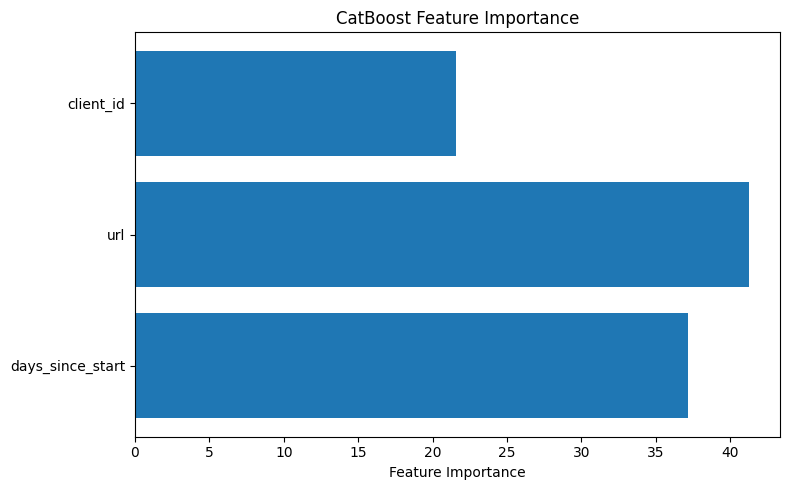

In [18]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

X = data_page.collect().to_pandas().head(100)
print(X.columns)
X = X.drop(columns=["timestamp"])
y = pd.Series(targets_page, name="target")

model = CatBoostClassifier(verbose=0)
model.fit(X, y)


importances = model.get_feature_importance()
features = X.columns

y_pred = model.predict(X)

acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.2f}")

for f, imp in zip(features, importances):
    print(f"{f}: {imp:.2f}")


plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

product_0 - Accuracy: 0.97
Accuracy: 0.97
client_id: 33.34
sku: 41.51
days_since_start: 25.15


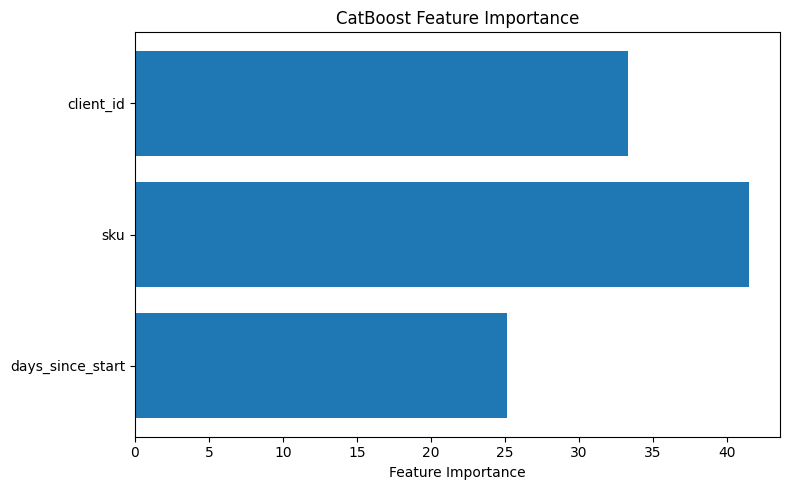

product_1 - Accuracy: 1.00
Accuracy: 1.00
client_id: 38.99
sku: 34.48
days_since_start: 26.53


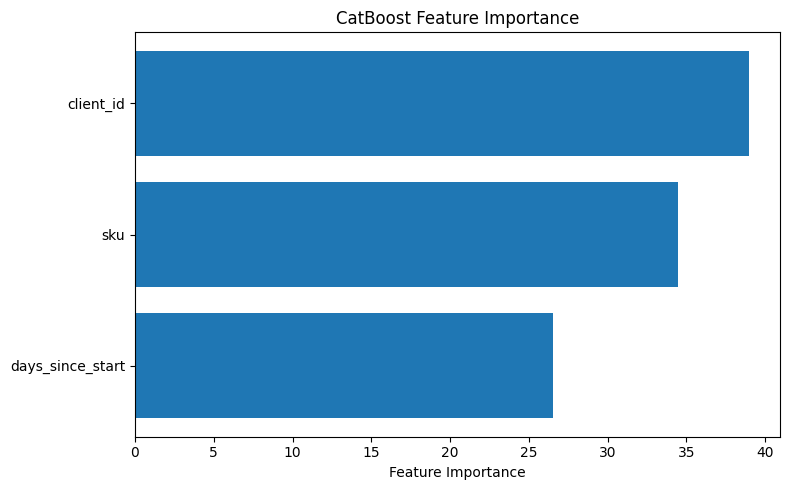

product_2 - Accuracy: 1.00
Accuracy: 1.00
client_id: 28.64
sku: 40.98
days_since_start: 30.38


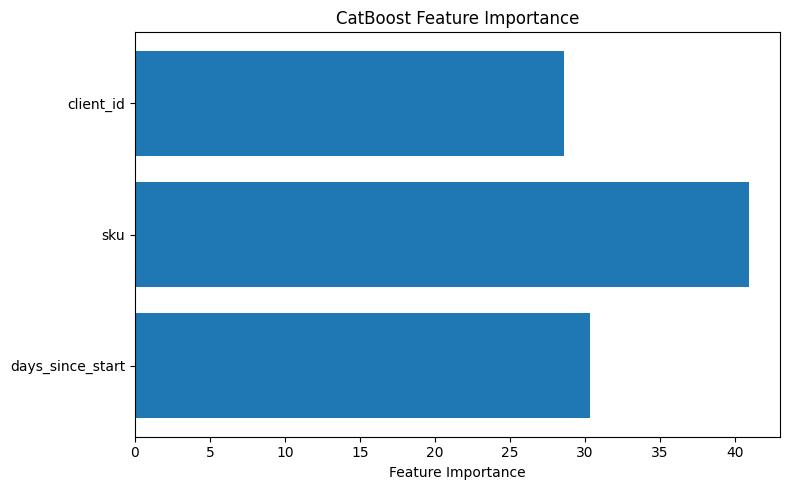

CatBoostError: catboost/private/libs/target/target_converter.cpp:404: Target contains only one unique value

In [ ]:
X = data_buy.collect().to_pandas().head(100)
X = X.drop(columns=["timestamp"])

# Convert the targets to a DataFrame
Y = pd.DataFrame(cat_targets, columns=[f"product_{i}" for i in range(len(cat_targets))])

models = {}
accuracies = {}

for product in Y.columns:
    y_product = Y[product]

    model = CatBoostClassifier(verbose=0)
    model.fit(X, y_product)

    if len(y_product.unique()) < 2:
        print(f"{product} - ommiting 1 class: {y_product.unique()[0]})")
        continue

    y_pred = model.predict(X)
    acc = accuracy_score(y_product, y_pred)
    accuracies[product] = acc
    models[product] = model

    print(f"{product} - Accuracy: {acc:.2f}")

    importances = model.get_feature_importance()
    features = X.columns

    y_pred = model.predict(X)

    acc = accuracy_score(y_product, y_pred)
    print(f"Accuracy: {acc:.2f}")

    for f, imp in zip(features, importances):
        print(f"{f}: {imp:.2f}")


    plt.figure(figsize=(8, 5))
    plt.barh(features, importances)
    plt.xlabel("Feature Importance")
    plt.title("CatBoost Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [21]:
propensity_sku = data["targets"]["propensity_sku"]
propensity_category = data["targets"]["propensity_category"]

buy_data = data["events"]["product_buy"]
cart_data = data["events"]["add_to_cart"]
remove_data = data["events"]["remove_from_cart"]

products = data["products"]["product_properties"]

product_buy_with_category = products.join(buy_data, on="sku", how="inner")
add_to_cart_with_category = products.join(cart_data, on="sku", how="inner")
remove_from_cart_with_category = products.join(remove_data, on="sku", how="inner")



prop_sku = PropensityTargetCalculator(PropensityTasks.PROPENSITY_SKU, propensity_sku)
sku_buy = []
sku_add = []
sku_remove = []

for client_id in active_clients_ids:
    sku_buy.append(prop_sku.compute_target(client_id, buy_data))
    sku_add.append(prop_sku.compute_target(client_id, cart_data))
    sku_remove.append(prop_sku.compute_target(client_id, remove_data))

prop_cat = PropensityTargetCalculator(PropensityTasks.PROPENSITY_CATEGORY, propensity_category)
cat_buy = []
cat_add = []
cat_remove = []

for client_id in active_clients_ids:
    cat_buy.append(prop_cat.compute_target(client_id, product_buy_with_category))
    cat_add.append(prop_cat.compute_target(client_id, add_to_cart_with_category))
    cat_remove.append(prop_cat.compute_target(client_id, remove_from_cart_with_category))



product_0 - ommiting 1 class: 0.0)
product_1 - ommiting 1 class: 0.0)
product_2 - ommiting 1 class: 0.0)
product_3 - ommiting 1 class: 0.0)
product_4 - ommiting 1 class: 0.0)
product_5 - ommiting 1 class: 0.0)
product_6 - ommiting 1 class: 0.0)
product_7 - ommiting 1 class: 0.0)
product_8 - ommiting 1 class: 0.0)
product_9 - ommiting 1 class: 0.0)
product_10 - ommiting 1 class: 0.0)
product_11 - ommiting 1 class: 0.0)
product_12 - ommiting 1 class: 0.0)
product_13 - ommiting 1 class: 0.0)
product_14 - ommiting 1 class: 0.0)
product_15 - ommiting 1 class: 0.0)
product_16 - ommiting 1 class: 0.0)
product_17 - ommiting 1 class: 0.0)
product_18 - ommiting 1 class: 0.0)
product_19 - ommiting 1 class: 0.0)
product_20 - Accuracy: 0.99
Accuracy: 0.99
client_id: 29.73
sku: 37.35
days_since_start: 32.92


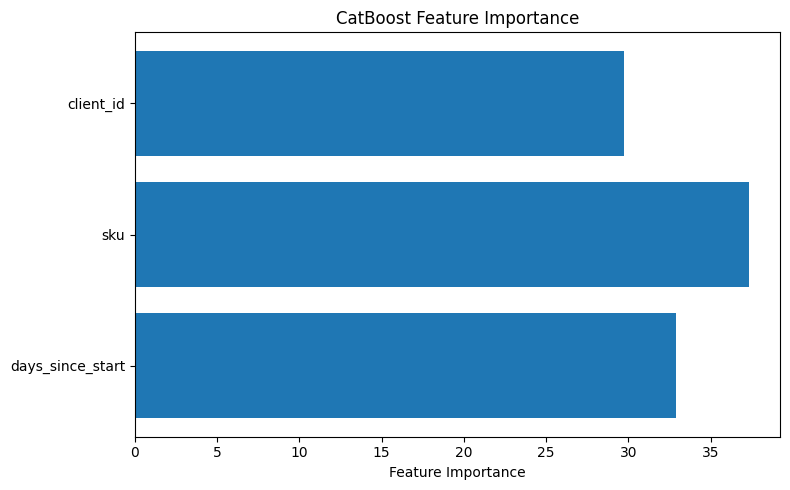

product_21 - ommiting 1 class: 0.0)
product_22 - ommiting 1 class: 0.0)
product_23 - ommiting 1 class: 0.0)
product_24 - ommiting 1 class: 0.0)
product_25 - ommiting 1 class: 0.0)
product_26 - ommiting 1 class: 0.0)
product_27 - ommiting 1 class: 0.0)
product_28 - ommiting 1 class: 0.0)
product_29 - ommiting 1 class: 0.0)
product_30 - ommiting 1 class: 0.0)
product_31 - ommiting 1 class: 0.0)
product_32 - ommiting 1 class: 0.0)
product_33 - ommiting 1 class: 0.0)
product_34 - ommiting 1 class: 0.0)
product_35 - ommiting 1 class: 0.0)
product_36 - ommiting 1 class: 0.0)
product_37 - ommiting 1 class: 0.0)
product_38 - ommiting 1 class: 0.0)
product_39 - ommiting 1 class: 0.0)
product_40 - ommiting 1 class: 0.0)
product_41 - ommiting 1 class: 0.0)
product_42 - ommiting 1 class: 0.0)
product_43 - ommiting 1 class: 0.0)
product_44 - ommiting 1 class: 0.0)
product_45 - ommiting 1 class: 0.0)
product_46 - ommiting 1 class: 0.0)
product_47 - ommiting 1 class: 0.0)
product_48 - ommiting 1 clas

In [32]:
X = remove_data.collect().to_pandas().head(100)
X = X.drop(columns=["timestamp"])

# Convert the targets to a DataFrame
Y = pd.DataFrame(sku_targets, columns=[f"product_{i}" for i in range(len(sku_targets))])

models = {}
accuracies = {}

for product in Y.columns:
    y_product = Y[product]

    model = CatBoostClassifier(verbose=0)
    if len(y_product.unique()) < 2:
        print(f"{product} - ommiting 1 class: {y_product.unique()[0]})")
        continue

    model.fit(X, y_product)

    

    y_pred = model.predict(X)
    acc = accuracy_score(y_product, y_pred)
    accuracies[product] = acc
    models[product] = model

    print(f"{product} - Accuracy: {acc:.2f}")

    importances = model.get_feature_importance()
    features = X.columns

    y_pred = model.predict(X)

    acc = accuracy_score(y_product, y_pred)
    print(f"Accuracy: {acc:.2f}")

    for f, imp in zip(features, importances):
        print(f"{f}: {imp:.2f}")


    plt.figure(figsize=(8, 5))
    plt.barh(features, importances)
    plt.xlabel("Feature Importance")
    plt.title("CatBoost Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

product_0 - Accuracy: 0.98
Accuracy: 0.98
sku: 24.93
category: 18.94
price: 24.52
client_id: 16.99
days_since_start: 14.62


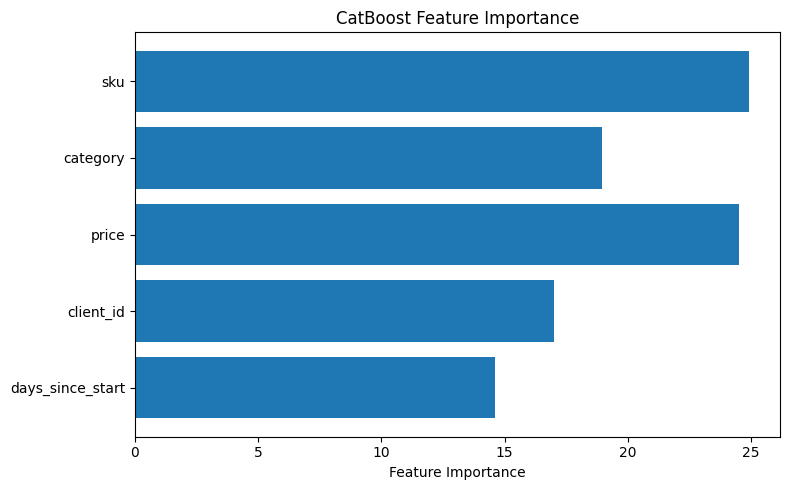

product_1 - Accuracy: 1.00
Accuracy: 1.00
sku: 22.52
category: 18.17
price: 20.47
client_id: 12.01
days_since_start: 26.83


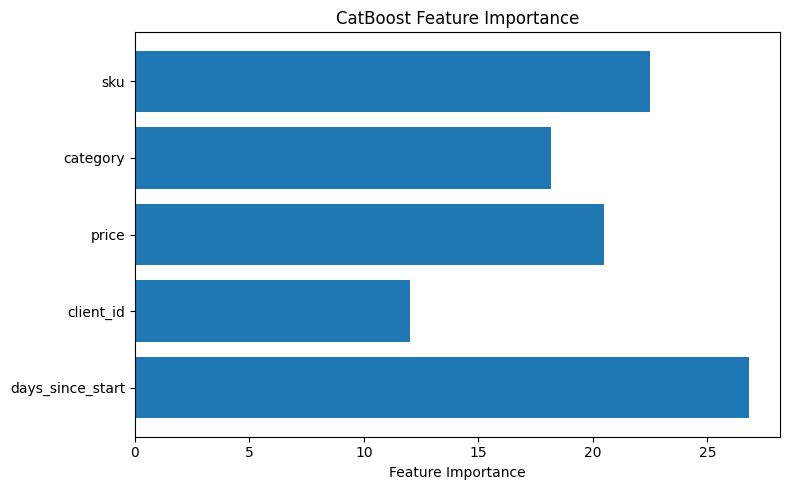

product_2 - Accuracy: 1.00
Accuracy: 1.00
sku: 23.12
category: 22.71
price: 19.78
client_id: 15.99
days_since_start: 18.39


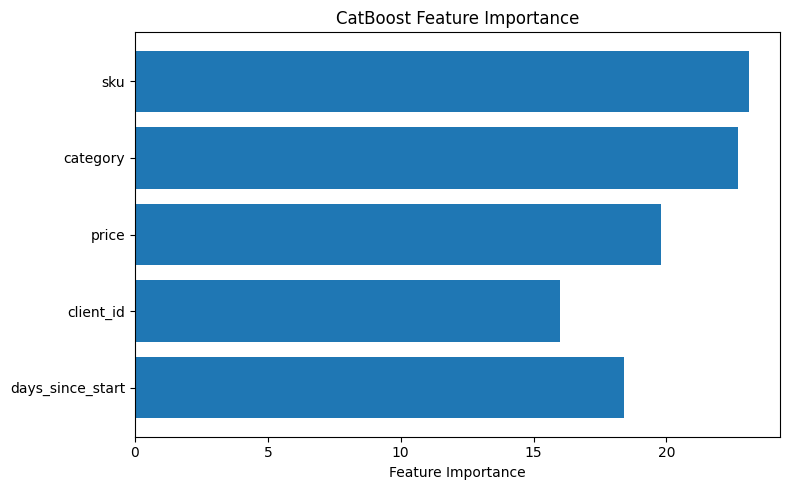

CatBoostError: catboost/private/libs/target/target_converter.cpp:404: Target contains only one unique value

In [26]:
X = remove_from_cart_with_category.collect().to_pandas().head(100)
X = X.drop(columns=["name"])
X = X.drop(columns=["timestamp"])

# Convert the targets to a DataFrame
Y = pd.DataFrame(cat_targets, columns=[f"product_{i}" for i in range(len(cat_targets))])

models = {}
accuracies = {}

for product in Y.columns:
    y_product = Y[product]

    model = CatBoostClassifier(verbose=0)
    model.fit(X, y_product)

    if len(y_product.unique()) < 2:
        print(f"{product} - ommiting 1 class: {y_product.unique()[0]})")
        continue

    y_pred = model.predict(X)
    acc = accuracy_score(y_product, y_pred)
    accuracies[product] = acc
    models[product] = model

    print(f"{product} - Accuracy: {acc:.2f}")

    importances = model.get_feature_importance()
    features = X.columns

    y_pred = model.predict(X)

    acc = accuracy_score(y_product, y_pred)
    print(f"Accuracy: {acc:.2f}")

    for f, imp in zip(features, importances):
        print(f"{f}: {imp:.2f}")


    plt.figure(figsize=(8, 5))
    plt.barh(features, importances)
    plt.xlabel("Feature Importance")
    plt.title("CatBoost Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()